## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.svm import l1_min_c, SVC
from time import time
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
import warnings

warnings.simplefilter('ignore')

## Reading Data

In [2]:
# Data Link
data = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00351/Mesothelioma%20data%20set.xlsx'

In [3]:
df = pd.read_excel(data, sheet_name='Data').drop('diagnosis method', axis=1)

print("Column headings:")
print(df.columns)

Column headings:
Index(['age', 'gender', 'city', 'asbestos exposure', 'type of MM',
       'duration of asbestos exposure', 'keep side', 'cytology',
       'duration of symptoms', 'dyspnoea', 'ache on chest', 'weakness',
       'habit of cigarette', 'performance status', 'white blood',
       'cell count (WBC)', 'hemoglobin (HGB)', 'platelet count (PLT)',
       'sedimentation', 'blood lactic dehydrogenise (LDH)',
       'alkaline phosphatise (ALP)', 'total protein', 'albumin', 'glucose',
       'pleural lactic dehydrogenise', 'pleural protein', 'pleural albumin',
       'pleural glucose', 'dead or not', 'pleural effusion',
       'pleural thickness on tomography', 'pleural level of acidity (pH)',
       'C-reactive protein (CRP)', 'class of diagnosis'],
      dtype='object')


In [4]:
df.head()

,age,gender,city,asbestos exposure,type of MM,duration of asbestos exposure,keep side,cytology,duration of symptoms,dyspnoea,...,pleural lactic dehydrogenise,pleural protein,pleural albumin,pleural glucose,dead or not,pleural effusion,pleural thickness on tomography,pleural level of acidity (pH),C-reactive protein (CRP),class of diagnosis
0,47.0,1,0,1,0.0,20.0,0,1,24.0,1,...,289.0,0.0,0.00,79.0,1,0.0,0.0,0.0,34,1
1,55.0,1,0,1,0.0,45.0,0,0,1.0,1,...,7541.0,1.6,0.80,6.0,1,1.0,1.0,1.0,42,1
2,29.0,1,1,1,0.0,23.0,1,0,1.0,0,...,480.0,0.0,0.00,90.0,1,0.0,0.0,0.0,43,2
3,39.0,1,0,1,0.0,10.0,0,0,3.0,0,...,459.0,5.0,2.80,45.0,1,1.0,0.0,0.0,21,1
4,47.0,1,0,1,0.0,10.0,1,1,1.5,1,...,213.0,3.6,1.95,53.0,1,1.0,0.0,0.0,11,1


Class of diagnosis: 1 = Health, 2 = Mesothelioma

In [5]:
df['class of diagnosis'].value_counts()

1    228
2     96
Name: class of diagnosis, dtype: int64

## Pre-processing

In this step we will separate our features into numerical and categorical.

The categorical data will be discretized and the final features will be normalized with zero mean and unit variance

In [6]:
cat = ['gender',
       'city',
       'asbestos exposure',
       'type of MM',
       'keep side',
       'cytology',
       'dyspnoea',
       'ache on chest',
       'weakness',
       'habit of cigarette',
       'performance status',
       'hemoglobin (HGB)',
       'dead or not',
       'pleural effusion',
       'pleural thickness on tomography',
       'pleural level of acidity (pH)']

num = ['age',
       'duration of asbestos exposure',
       'duration of symptoms',
       'white blood',
       'cell count (WBC)',
       'platelet count (PLT)',
       'sedimentation',
       'blood lactic dehydrogenise (LDH)',
       'alkaline phosphatise (ALP)',
       'total protein',
       'albumin',
       'glucose',
       'pleural lactic dehydrogenise',
       'pleural protein',
       'pleural albumin',
       'pleural glucose',
       'C-reactive protein (CRP)']

df_cat = pd.get_dummies(data=df[cat].astype(object), drop_first=False) # categorical_df
df_num = df[num].copy() # numerical_df

X = pd.concat([df_cat, df_num],axis=1)
y = df['class of diagnosis'].map({1: 0, 2: 1}).values

sc = StandardScaler() # normalization
X_norm = sc.fit_transform(X.values)

### Logistic Regresion performance

First, we will see how the Logistic Regression Classifier will perform using a stratified cross-validation.

In [7]:
lr = LogisticRegression(penalty='l1', solver='liblinear',
                         tol=1e-6, max_iter=int(1e6),
                         warm_start=True, random_state=0)

skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=0)

In [8]:
print('Accuracy:\t%.2f%%\t-\t' % (100*cross_val_score(lr, 
                                                     X_norm,
                                                     y, cv=skf, scoring='accuracy').mean()), 
      end='')
print(cross_val_score(lr, X_norm, y, cv=skf, scoring='accuracy'))

print('ROC_AUC:\t%.2f%%\t-\t' % (100*cross_val_score(lr, 
                                                     X_norm,
                                                     y, cv=skf, scoring='roc_auc').mean()), 
      end='')
print(cross_val_score(lr, X_norm, y, cv=skf, scoring='roc_auc'))

Accuracy:	70.06%	-	[0.69135802 0.72839506 0.66666667 0.71604938]
ROC_AUC:	65.92%	-	[0.61769006 0.7251462  0.58845029 0.70540936]


### Optimizing Lasso regularization on LR

In this step we will split the dataset in a train_test_split and optimize the L1 regularization by its hyperparameter C.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, y,
                                                    random_state=0,
                                                    stratify=y, 
                                                    test_size=0.25)

cs = l1_min_c(X_norm, y, loss='log') * np.logspace(0.5, 2, 30) # different values of C

Computing regularization path ...
***	AUC: 0.5274	-	F1-Score: 0.1935	-	Eliminate 59 features
	AUC: 0.5274	-	F1-Score: 0.1935	-	Eliminate 59 features
	AUC: 0.5274	-	F1-Score: 0.1935	-	Eliminate 59 features
	AUC: 0.5274	-	F1-Score: 0.1935	-	Eliminate 58 features
	AUC: 0.5274	-	F1-Score: 0.1935	-	Eliminate 54 features
	AUC: 0.5274	-	F1-Score: 0.1935	-	Eliminate 52 features
	AUC: 0.5274	-	F1-Score: 0.1935	-	Eliminate 52 features
	AUC: 0.5274	-	F1-Score: 0.1935	-	Eliminate 48 features
	AUC: 0.5274	-	F1-Score: 0.1935	-	Eliminate 44 features
	AUC: 0.5274	-	F1-Score: 0.1935	-	Eliminate 40 features
	AUC: 0.5186	-	F1-Score: 0.1875	-	Eliminate 34 features
	AUC: 0.5186	-	F1-Score: 0.1875	-	Eliminate 33 features
***	AUC: 0.5636	-	F1-Score: 0.3243	-	Eliminate 31 features
***	AUC: 0.5724	-	F1-Score: 0.3333	-	Eliminate 29 features
***	AUC: 0.5932	-	F1-Score: 0.3784	-	Eliminate 29 features
	AUC: 0.5932	-	F1-Score: 0.3784	-	Eliminate 29 features
	AUC: 0.5932	-	F1-Score: 0.3784	-	Eliminate 28 features
	A

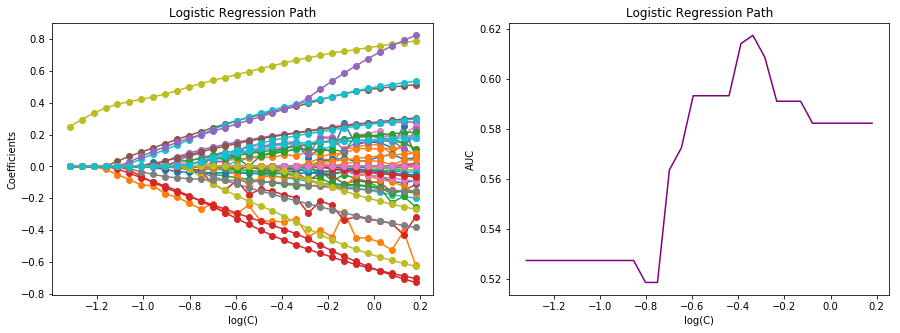

In [16]:
print("Computing regularization path ...")
start = time()
coefs_ = []
auc_ = []
f1_ = []
max_auc = 0
for c in cs:
    lr.set_params(C=c)
    lr.fit(X_train, y_train)
    coefs_.append(lr.coef_.ravel().copy())
    auc = roc_auc_score(y_test, lr.predict(X_test))
    f1 = f1_score(y_test, lr.predict(X_test))
    auc_.append(auc)
    f1_.append(f1)
    if(auc>max_auc):
        print('***\tAUC: %.4f\t-\tF1-Score: %.4f\t-\tEliminate %d features' % 
              (auc, f1, np.where(lr.coef_.ravel()==0)[0].shape[0]))
        max_auc = auc
    else:
        print('\tAUC: %.4f\t-\tF1-Score: %.4f\t-\tEliminate %d features' % 
              (auc, f1, np.where(lr.coef_.ravel()==0)[0].shape[0]))
print("This took %0.3fs" % (time() - start))

coefs_ = np.array(coefs_)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=((15,5)))
ax[0].plot(np.log10(cs), coefs_, marker='o')
ax[0].set_xlabel('log(C)'); ax[0].set_ylabel('Coefficients'); ax[0].set_title('Logistic Regression Path')

ax[1].plot(np.log10(cs), auc_, color='purple')
ax[1].set_xlabel('log(C)'); ax[1].set_ylabel('AUC'); ax[1].set_title('Logistic Regression Path')

plt.show()

Lets see which features will be really dropped (all dummies if categorical) by the L1 Regularization (coefficients will go to zero).

In [11]:
final_coefs = coefs_[np.argmax(auc_)]

feats = np.unique([x.split('_')[0] for x in X.iloc[:,np.where(final_coefs != 0)[0]].columns])
print('Relevant Features remaining: %d\n' % (feats.shape[0]))
print(feats)

dropped = np.unique([x for x in cat+num if x not in feats])
print('\n\nDropped features: %d\n' % (dropped.shape[0]))
print(dropped)

Relevant Features remaining: 23

['C-reactive protein (CRP)' 'age' 'alkaline phosphatise (ALP)'
 'cell count (WBC)' 'city' 'cytology' 'duration of asbestos exposure'
 'duration of symptoms' 'dyspnoea' 'gender' 'habit of cigarette'
 'hemoglobin (HGB)' 'keep side' 'performance status'
 'platelet count (PLT)' 'pleural albumin' 'pleural glucose'
 'pleural level of acidity (pH)' 'pleural thickness on tomography'
 'sedimentation' 'total protein' 'type of MM' 'weakness']


Dropped features: 10

['ache on chest' 'albumin' 'asbestos exposure'
 'blood lactic dehydrogenise (LDH)' 'dead or not' 'glucose'
 'pleural effusion' 'pleural lactic dehydrogenise' 'pleural protein'
 'white blood']


## Final Model - SVM

A grid search on some of the SVM Classifier hyperparams will be performed on the data with the features selected on the steps above and it will be our final model.

In [12]:
gs = GridSearchCV(SVC(random_state=0, tol=1e-6, max_iter=int(1e6)), 
                  {'C': cs,
                   'kernel': ['linear', 'poly', 'rbf'],
                   'class_weight': ['balanced', None]},
                  scoring='roc_auc',
                  cv=skf, n_jobs=-1).fit(X_norm[:,np.where(final_coefs != 0)[0]],y)

svm = SVC(random_state=0, tol=1e-6, max_iter=int(1e6), **gs.best_params_)

gs.best_params_

{'C': 1.5151515151515151, 'class_weight': None, 'kernel': 'rbf'}

Lets see our final metrics:

In [13]:
print('Accuracy:\t%.2f%%\t-\t' % (100*cross_val_score(svm, 
                                                      X_norm[:,np.where(final_coefs != 0)[0]],
                                                      y, cv=skf, scoring='accuracy').mean()), 
      end='')
print(cross_val_score(svm, X_norm[:,np.where(final_coefs != 0)[0]], y, cv=skf, scoring='accuracy'))

print('ROC_AUC:\t%.2f%%\t-\t' % (100*cross_val_score(svm, 
                                                     X_norm[:,np.where(final_coefs != 0)[0]],
                                                     y, cv=skf, scoring='roc_auc').mean()), 
      end='')
print(cross_val_score(svm, X_norm[:,np.where(final_coefs != 0)[0]], y, cv=skf, scoring='roc_auc'))

Accuracy:	75.00%	-	[0.72839506 0.7654321  0.71604938 0.79012346]
ROC_AUC:	74.05%	-	[0.73464912 0.75584795 0.69005848 0.78143275]


Lets compare our final model if we didn't use Logistic Regression Lasso feature selection:

In [14]:
print('Accuracy:\t%.2f%%\t-\t' % (100*cross_val_score(svm, 
                                                     X_norm,
                                                     y, cv=skf, scoring='accuracy').mean()), 
      end='')
print(cross_val_score(svm, X_norm, y, cv=skf, scoring='accuracy'))

print('ROC_AUC:\t%.2f%%\t-\t' % (100*cross_val_score(svm, 
                                                     X_norm,
                                                     y, cv=skf, scoring='roc_auc').mean()), 
      end='')
print(cross_val_score(svm, X_norm, y, cv=skf, scoring='roc_auc'))

Accuracy:	74.38%	-	[0.71604938 0.75308642 0.71604938 0.79012346]
ROC_AUC:	67.73%	-	[0.6622807  0.70394737 0.62207602 0.72076023]
